# Open Science Prize 2021 Report 
by. Xiaopeng Duan

# 1 Introduction

## 1-1 Problem
Quanatum simulation of the $XXX$ Heisenberg Spin Model of three spins using Trotterization for $t=\pi$:
$$
H_{\text{Heis3}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}.
$$

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right]
\end{align}
$$
The three spins (0,1,2) are mapped to qubit 1, 3, nad 5 on Ibmq_jakarta respectively. 

In this report, $\sigma_{x,y,z}$ and $X, Y, Z$ are used interchangably.

## 1-2 Solution summay
This solution is built upon three major components:
1. Double Cross Resonance gates (DCR). This is the core machnism to realized spin interations and it is the only type of multi-qubit gates used in the final quantum circuits.
2. The error mitigation techniques is used to suppress single qubit rotation and measurement errors.
3. The Zeron Noise Extrapolation technique is used to reduce depolarization errors from DCR gates.
4. Some calibration circuits are added within the same job to select the best DCR schedule parameters.

For a given Trotterization (i.e. a choice of trotter steps, the order and the Hamiltonian ordering), the complete framework is described by the following steps:

$\textbf{Step 1.}$ Generate the error mitigation circuit by removing all GaussianSquare pulses in the full Trotterization circuit (8 circuits for original setting and 8 for the noise amplified setting for zero noise extrapoltion).

$\textbf{Step 2.}$ Generate the calibration circuits for a single DCR gate with 5 different parameters for a time evolation of $target\_time/trotter\_steps$ (5 circuits).

$\textbf{Step 3.}$ Generate the full state tomography circuits with the 5 different parameters ($2\times 5\times 27 = 270$ circuits).

$\textbf{Step 4.}$ Run the total 291 circuits.

$\textbf{Step 5.}$ Built the error mitigators. There will be two mitigators corresponding to the two ZNE sets.

$\textbf{Step 6.}$ Apply the corresponding mitigator to the corresponding tomography circuits results.

$\textbf{Step 7.}$ Choose according to the calibration circuits results for the best parameter choice.

$\textbf{Step 8.}$ Pick the results corresponding to the best parameter choice and run state tomography on both ZNE sets.

$\textbf{Step 9.}$ Calculate the extrapolated density matrix according to the ZNE formular.

$\textbf{Step 10.}$ Calculate the state fidelity using the extrapolated density matrix.

## 1-3 Result summary and discussion
This solution has reached a fidelity of $\textbf{0.9570}$ (details in section 4-1). However, by the time of submission, only one repeatition has finished.

Full evaluation has finished without the included calibration. The control pulse ratio is assigned with a heuristic value of 0.66. The achieved fedility over 8 repetitions is ($\textbf{average at 0.90, std at 0.003}$) with the best and worse repetitions both removed, or (average at 0.86, std at 0.12) with all 8 results. This experiment uses 4 steps first order Trotterization formular. The contributions from error mitigation and ZNE can be observed from further analyzing the first order four step trotterization results. Without ZNE, the average fidelity is about 0.89. The raw DCR based circuit without any other techniques gives an average fidelity about 0.71. Adding ZNE alone (no error mitigation) improves this to around 0.86. The details are presented in section 4-2.

While postprocessing techniques could improve the final fidelity, the core part of this solution is the DCR gate, which alone could reach over 0.7 fidelity. Further improvement beyond the current best fidelity of 0.95 would need more careful tuning of the DCR gate parameters. More parameters beyond the control pulse ratio and the phase shift may need to be tuned freely for most accurate behaviors. It may also take advantage of finer grained cancellation and echo pulse schemes. Given its simple physical picture and the unversality the in 3-spin interaction, it could be a useful addition to the general gate library.

## 1-4 Outline of this notebook
$\textbf{Section 2:}$ The theoretical background of DCR gate, implementation considerations and its integrtion with error mitigation and ZNE.

$\textbf{Section 3:}$ Implementation details with Qiskit Pulse for each component and some characterization experiement results.

$\textbf{Section 4:}$ Real device results for the complete tomography flow to demonstrate the fidelity performance.

$\textbf{Section 5:}$ Code/instructions to rerun the tomography experiment to reproduce the fidelity.

## 1-5 Files in this submission
$\textbf{base.py}$: The final python code file to support this solution.

$\textbf{base_1.py}$: An earlier version of the final code. It is only used to match with the real device experiments to process the results.

$\textbf{util.py}$: The even earlier version to support the component-wise experiments. Used in section 3 for some plots. It also include an abondoned gate based solution that achieves a final average fidelity around 0.76. 

# 2 Technical details
## 2-1 Double cross resonance gate
### 2-1-1 Physics principles
The cross resonance (CR) gate is physically native to Ibmq_jakarta which realizes the time evolation for Hamiltonin $H_{CR}=ZX$$. In principle, it is realized by applying a pulse at target qubit frequency to the control qubit. Since there is no pulse applied to the target qubit (let's temporarily ignore the cancellation pulse), an interesting extension is to add another control qubit. Another pulse at the target qubit frequency can be applied to the new control qubit independently from the first one. As a result, two CR gates are simulteneously applied on the same target qubit and intuitively the governing Hamiltonian is expected to be the summation of both, i.e. $H_{DCR}=Z^{(0)}X^{(1)}+X^{(1)}Z^{(2)}$ with qubit 1 being the target qubit. Following a similar procedure as in ref.\[1\], we can derive this Hamiltonian in driving frame as:

$$
\begin{equation}
\frac{2}{\hbar}H_{DCR} = \sigma_0^z + \sigma_2^z + \frac{\omega_{01}^{xx}}{2}\frac{\Omega_0}{\delta_0}(\sigma_0^z \sigma_1^x \cos\phi_0 + \sigma_0^z \sigma_1^y \sin\phi_0) + \frac{\omega_{21}^{xx}}{2}\frac{\Omega_2}{\delta_2}(\sigma_2^z \sigma_1^x \cos\phi_2 + \sigma_2^z \sigma_1^y \sin\phi_2)
\end{equation}
$$

where $\omega_{**}^{xx}$, $\delta_*$, $\Omega_*$ and $\phi_*$ are the coupling cofficients/frequence-difference between the corresponding qubits and the amplitude/phase of the corresponding pulses. This two-level base Hamiltonian derivation lacks the details captured by energy basis based Hamiltonian analysis from ref.\[2\], but it confirms the possibility of realizing the expected DCR gate. If properly tuned, this gate should provide a much short circuit duration than applying the two-qubits interactions consecutively and thus better fideleity. 

### 2-1-2 Practical consideration
In practice for a CR gate, apart from the control pulse, a cancellation pulse is applied to the target qubit to suppress the unwanted/secondary terms in a more regious Hamiltonian. When it is extended for the second control qubit, another cancellation has to be applied to the same driving channel for the target qubit. How those two cancellation pulses are combine could be an important question for good DCR gate performance. Without further theoretical derivation or comparison experiments, a simple summation strategy is used in this report as an intuitive choice. 

The additional control qubit also induce more choices on echos. Echoing is used in CR gate to suppress terms like $ZI$ for the CX gate. With two control bits, we can have finer grained echos, i.e. reverting each one and revert both. Due to time limit, only one echo is used in this report that reverts both control qubits.

### 2-1-3 From $H_{DCR}$ to $H_{Heis3}$
The Heisenberg spin Hamiltonian is decomposed as:

\begin{equation}
H_{Heis3} = (X_0 X_1 + X_1 X_2) + (Y_0 Y_1 + Y_1 Y_2) + (Z_0 Z_1 + Z_1 Z_2) = H_X + H_Y + H_Z
\end{equation}

The time evoluation of each $H_{X,Y,Z}$ can be realized by sandwiching DCR gate by single qubit rotations:

\begin{equation}
\exp(-itH_x) = R_0^y(\frac{\pi}{2})R_2^y(\frac{\pi}{2})R_{DCR}(2t)R_0^y(-\frac{\pi}{2})R_2^y(-\frac{\pi}{2})
\end{equation}

\begin{equation}
\exp(-itH_y) = R_0^x(-\frac{\pi}{2})R_1^z(\frac{\pi}{2})R_2^x(-\frac{\pi}{2})R_{DCR}(2t)R_0^x(\frac{\pi}{2})R_1^z(-\frac{\pi}{2})R_2^x(\frac{\pi}{2})
\end{equation}

\begin{equation}
\exp(-itH_z) = R_1^y(-\frac{\pi}{2})R_{DCR}(2t)R_1^y(\frac{\pi}{2})
\end{equation}

where $R_{DCR}=\exp(-\frac{1}{2}it H_{DCR})$ is the rotation induced by the DCR gate. Each Trotterization step is given by:
\begin{equation}
\exp(-itH_{heis3}) = \exp(-itH_x)\exp(-itH_z)\exp(-itH_y)
\end{equation}

for  the first order and the second order is:
\begin{equation}
\exp(-itH_{heis3}) = \exp(-i\frac{t}{2}H_x)\exp(-i\frac{t}{2}H_z)\exp(-itH_y)\exp(-i\frac{t}{2}H_z)\exp(-i\frac{t}{2}H_x)
\end{equation}

The 'xzy' order is chosen for the best performance.

### 2-1-4 Implementation on Ibmq_jakarta
To avoid tuning DCR gate from scratch, the implementation follows a similar manner as the $RZXCalibrationBuilder$ from Qiskit library. The tuned CX schedule is extracted from the backend's $instruction\_schedule\_map$ and the parameters are scaled according to the target rotation angle value. 

One non-trivial issue is that the backend does not have tuned CR schedule for all directions. For instance with qubits 3 and 5, both CX(3,5) and CX(5,3) are built upon the same CR schedule CR(3,5), and for qubits 1 and 3, both relies on CR(1,3). As a workaround when setting parameters for DCR gate, the control pulse applied on qubit 5 and its concellation pulses are set in reference to the values from CR(1,3):

\begin{equation}
\Omega_5 = \gamma \Omega_1^{CR(1,3)}
\end{equation}

\begin{equation}
\phi_5 = \Delta\phi + \phi_1^{CR(1,3)}
\end{equation}

\begin{equation}
\Omega_3 = (1+\gamma)\Omega_3^{CR(1,3)}
\end{equation}

The parameters $\gamma$ and $\Delta\phi$ are used to tune the DCR gate in the experiments for this report. It turned out $\gamma$ has the dominant influence while that from $\Delta\phi$ is ignorable for values near $0$. 

### 2-1-5 Reversed DCR gate
For Zero Noise Extrapolation (ZNE), the noisy gates have to be multipled to increase the noise contribution to enable the extrapolation. For DCR gate, it can be realized by replacing $R_{DCR}(T)$ with $R_{DCR}(t)R_{DCT}^{\dagger}(t)R_{DCR}(t)$ with the assumption that $R_{DCR}(t)$ and $R_{DCR}^{\dagger}(t)$ have similar noise profiles. Without any regious provement, this assumption is accepted and effort is made to realize $R_{DCR}^{\dagger}(t)$ with minimal difference from $R_{DCR}(t)$. This is done by adding a $\pi$ shift to all the phase values in the GaussianSquare pulses, while everything else stays untouched.

## 2-2 Error mitigation
One interesting feature of the DCR gate based Heisenberg model simulation circuit is that the circuit reduces to an identity operator if all coupling pulses are removed. As a result, the standard error mitigation technique from from $CompleteMeasFitter$ in Qiskit library can be applied to mitigate both set/measure and single qubit rotation errors. In the implementation, the circuits are build with $t=0$ for all DCR gates. The resulting schedule will have all GaussianSquare pulses removed while all other pulses are identical to a $t\neq 0$ one. This allow the error mitigator to help reduce all non-coupling error as much as possible.

## 2-3 Zero Noise Extrapolation
With both $R_{DCR}$ AND $R_{DCR}^{\dagger}$ available and the assumption that they have similar noise profiles, the simple fixed identity insertion ZNE method as described in ref \[3\] can be easily applied. The original circuit corresponds to $r=0$ and with $R_{DCR}R_{DCR}^{\dagger}R_{DCR}$ substitution it corresponds to $r=3$. The extrapolated density matrix ($\rho_{ex}$) for zero noise is follows:

\begin{equation}
\rho_{ex} = 1.5\rho_{r=0} - 0.5\rho_{r=3}
\end{equation}

$\rho_{ex}$ is then used to calculate the final fidelity.

# 3 Implementation details with Qiskit

This section is intended to illustrate the implementated component of the solution. It is not a step-by-step run of the experiment. The experiment code is in Section 5.


# 3-1 DCR pulse and one Trotter step schedule

In [1]:
### import all base code/module
from base import *

In [2]:
bk = get_backend('jakarta', 1)

getting backend: jakarta


In [3]:
# DCR pulse parameters
qubits = [3,1,5] # [target, control1, control2]
theta = np.pi/4 # an arbitrary value for illustration
c2r = 0.6 # the amplitude of the second control pulse over the first one
dphi = 0 # phase difference between two control pulses
pvals = get_pnvals(bk, qubits, theta*2, 0.6, 0)
print(pvals)

{'ampt': 0.10489478077697134, 'phit': -0.03028729175139003, 'sigmat': 64, 'durationt': 704, 'widtht': 448, 'ampc0': 0.793036632011715, 'phic0': -2.830959183298184, 'sigmac0': 64, 'durationc0': 704, 'widthc0': 448, 'ampc1': 0.475821979207029, 'phic1': -2.830959183298184, 'sigmac1': 64, 'durationc1': 704, 'widthc1': 448}


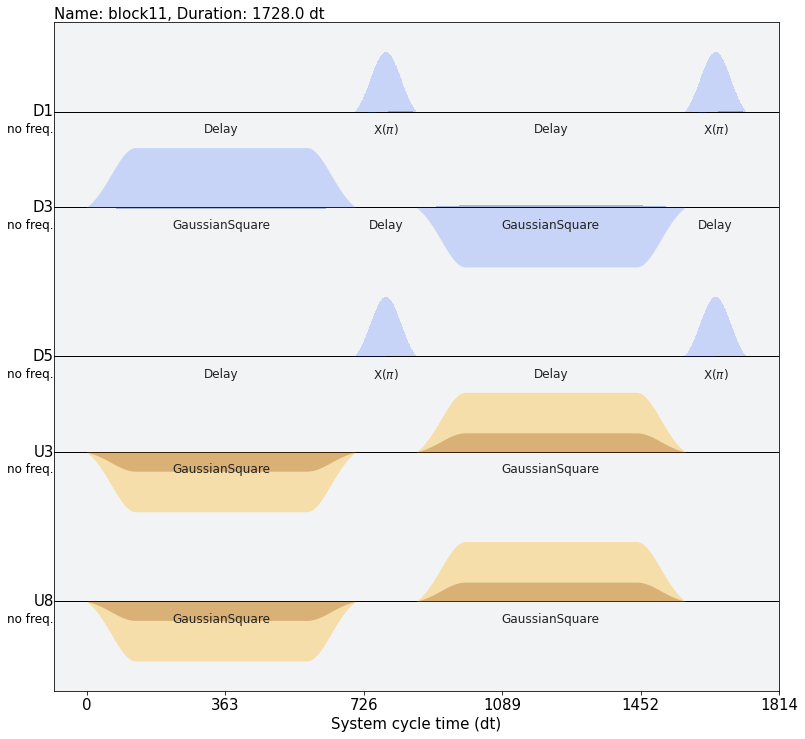

In [4]:
# The DCR pulse schedule
cg, cgd = create_cr_gate_schd2(bk, qubits, pvals, 'dcr')
cg['schedule'].draw()

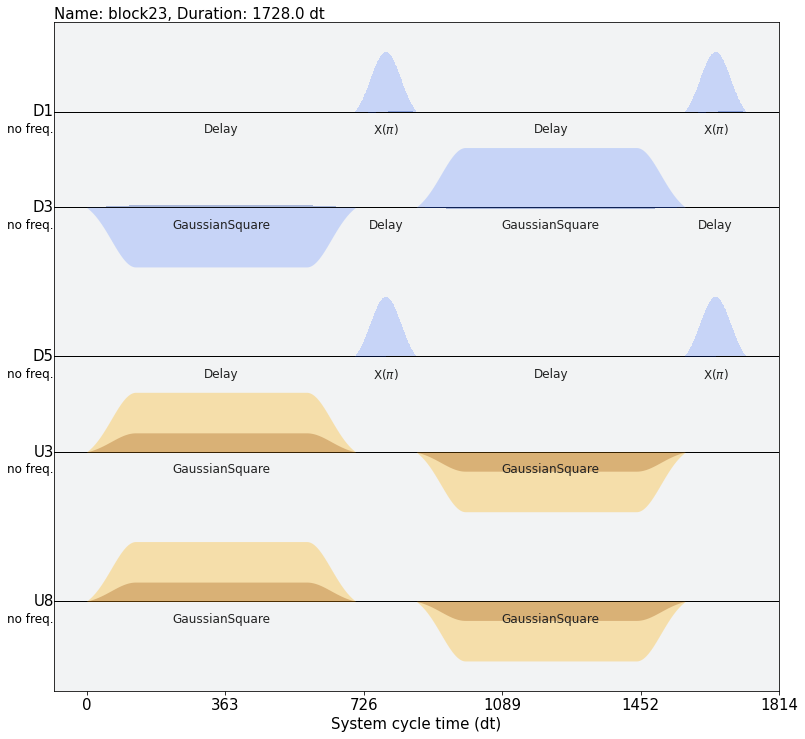

In [5]:
# the reversed pulse for DRC
cgd['schedule'].draw()

In [6]:
# One Trotter step
qc = QuantumCircuit(7)
add_one_trotter_step(bk, qc, qubits, None, None, cg, cgd, theta, 'xzy', 1, 0)
qc.draw()

»
q_0: ─────────────────────────────────────────────────────────────────────»
     ┌──────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐             »
q_1: ┤ Ry(-π/2) ├┤1        ├┤ Ry(π/2) ├┤1        ├┤ Rx(π/2) ├─────────────»
     └──────────┘│         │└─────────┘│         │└─────────┘             »
q_2: ────────────┤         ├───────────┤         ├────────────────────────»
                 │         │┌─────────┐│         │┌──────────┐┌──────────┐»
q_3: ────────────┤0 dcr315 ├┤ Ry(π/2) ├┤0 dcr315 ├┤ Ry(-π/2) ├┤ Rz(-π/2) ├»
                 │         │└─────────┘│         │└──────────┘└──────────┘»
q_4: ────────────┤         ├───────────┤         ├────────────────────────»
     ┌──────────┐│         │┌─────────┐│         │┌─────────┐             »
q_5: ┤ Ry(-π/2) ├┤2        ├┤ Ry(π/2) ├┤2        ├┤ Rx(π/2) ├─────────────»
     └──────────┘└─────────┘└─────────┘└─────────┘└─────────┘             »
q_6: ─────────────────────────────────────────────────────────────────────»
                                                                          »
«                            
«q_0: ───────────────────────
«     ┌─────────┐┌──────────┐
«q_1: ┤1        ├┤ Rx(-π/2) ├
«     │         │└──────────┘
«q_2: ┤         ├────────────
«     │         │┌─────────┐ 
«q_3: ┤0 dcr315 ├┤ Rz(π/2) ├─
«     │         │└─────────┘ 
«q_4: ┤         ├────────────
«     │         │┌──────────┐
«q_5: ┤2        ├┤ Rx(-π/2) ├
«     └─────────┘└──────────┘
«q_6: ───────────────────────
«

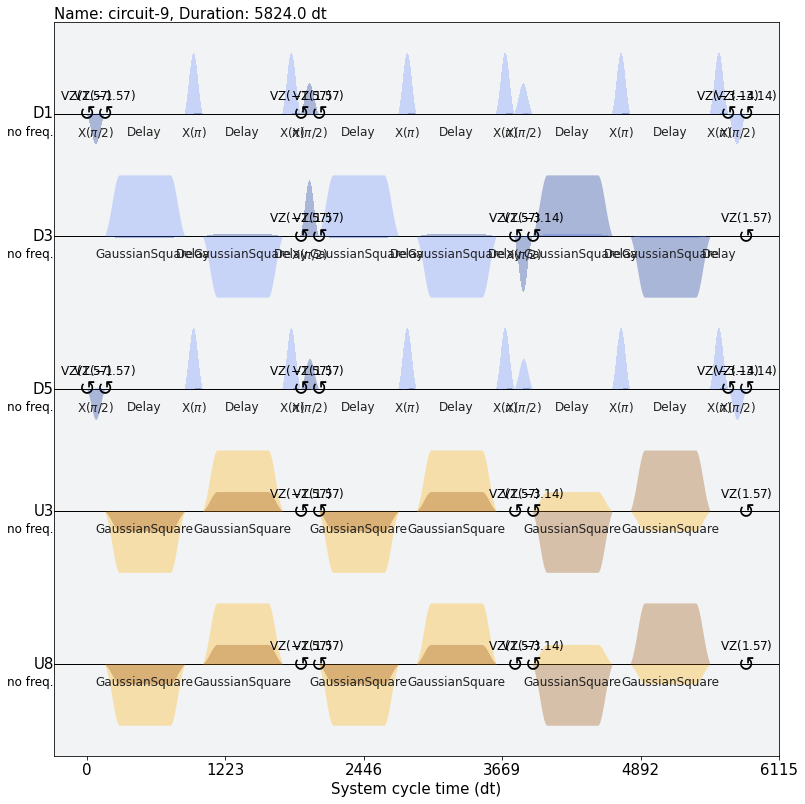

In [7]:
# One Trotter step schedulea
qc.add_calibration(cg['gate'], cg['qubits'], cg['schedule'])
qct = transpile(qc, bk)
schd = schedule(qct, bk)
schd.draw()

In [8]:
# One Trotter step with repeated DCR for ZNE
qc = QuantumCircuit(7)
add_one_trotter_step(bk, qc, qubits, None, None, cg, cgd, theta, 'xzy', 1, 1)
qc.draw()

»
q_0: ───────────────────────────────────────────────────────────────────────»
     ┌──────────┐┌─────────┐┌─────────────┐┌─────────┐┌─────────┐┌─────────┐»
q_1: ┤ Ry(-π/2) ├┤1        ├┤1            ├┤1        ├┤ Ry(π/2) ├┤1        ├»
     └──────────┘│         ││             ││         │└─────────┘│         │»
q_2: ────────────┤         ├┤             ├┤         ├───────────┤         ├»
                 │         ││             ││         │┌─────────┐│         │»
q_3: ────────────┤0 dcr315 ├┤0 dcr315_dag ├┤0 dcr315 ├┤ Ry(π/2) ├┤0 dcr315 ├»
                 │         ││             ││         │└─────────┘│         │»
q_4: ────────────┤         ├┤             ├┤         ├───────────┤         ├»
     ┌──────────┐│         ││             ││         │┌─────────┐│         │»
q_5: ┤ Ry(-π/2) ├┤2        ├┤2            ├┤2        ├┤ Ry(π/2) ├┤2        ├»
     └──────────┘└─────────┘└─────────────┘└─────────┘└─────────┘└─────────┘»
q_6: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                                                  »
«q_0: ─────────────────────────────────────────────────────────────»
«     ┌─────────────┐┌─────────┐┌─────────┐             ┌─────────┐»
«q_1: ┤1            ├┤1        ├┤ Rx(π/2) ├─────────────┤1        ├»
«     │             ││         │└─────────┘             │         │»
«q_2: ┤             ├┤         ├────────────────────────┤         ├»
«     │             ││         │┌──────────┐┌──────────┐│         │»
«q_3: ┤0 dcr315_dag ├┤0 dcr315 ├┤ Ry(-π/2) ├┤ Rz(-π/2) ├┤0 dcr315 ├»
«     │             ││         │└──────────┘└──────────┘│         │»
«q_4: ┤             ├┤         ├────────────────────────┤         ├»
«     │             ││         │┌─────────┐             │         │»
«q_5: ┤2            ├┤2        ├┤ Rx(π/2) ├─────────────┤2        ├»
«     └─────────────┘└─────────┘└─────────┘             └─────────┘»
«q_6: ─────────────────────────────────────────────────────────────»
«                                                                  »
«                                           
«q_0: ──────────────────────────────────────
«     ┌─────────────┐┌─────────┐┌──────────┐
«q_1: ┤1            ├┤1        ├┤ Rx(-π/2) ├
«     │             ││         │└──────────┘
«q_2: ┤             ├┤         ├────────────
«     │             ││         │┌─────────┐ 
«q_3: ┤0 dcr315_dag ├┤0 dcr315 ├┤ Rz(π/2) ├─
«     │             ││         │└─────────┘ 
«q_4: ┤             ├┤         ├────────────
«     │             ││         │┌──────────┐
«q_5: ┤2            ├┤2        ├┤ Rx(-π/2) ├
«     └─────────────┘└─────────┘└──────────┘
«q_6: ──────────────────────────────────────
«

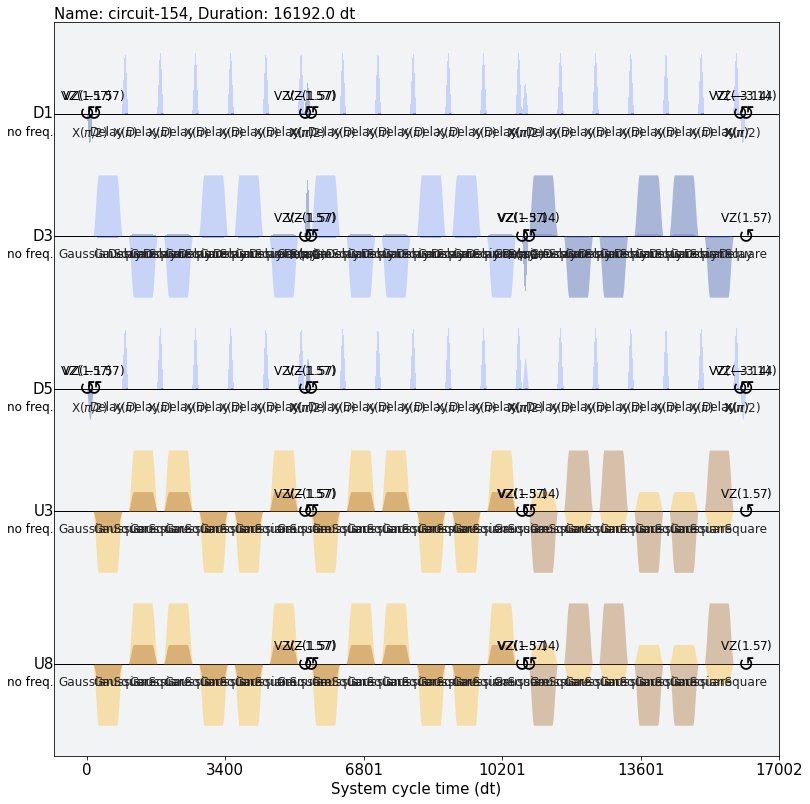

In [9]:
# One Trotter step schedulea
qc.add_calibration(cg['gate'], cg['qubits'], cg['schedule'])
qc.add_calibration(cgd['gate'], cgd['qubits'], cgd['schedule'])
qct = transpile(qc, bk)
schd = schedule(qct, bk)
schd.draw()

## 3-2 DCR gate behavior on Ibmq-jakarta

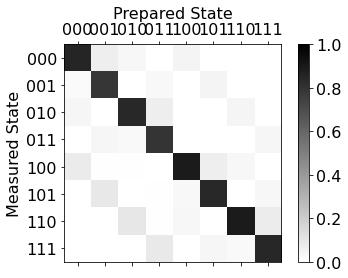

In [10]:
# Time evolution of DCR
# the retrieved jobs has error mitigation circuit and the single DCR gate at variation time/parameters
job = bk.retrieve_job('6253cb0ba5d4ee41a577eb85')
result = job.result()

## or load from saved results if the job has been removed.
#import pickle
#with open('result_dcr_tval.pk', 'rb') as fp:
#    result = pickle.load(fp)

# the parameters used in this experiment
c2r = [0.66, 0.77]
dphi = [0]
s0 = [One^One^Zero]
theta = np.linspace(0, np.pi, 45)
meas = ['xxx', 'yyy', 'zzz'] # not all result will be presented in this notebook
# apply error mitigation
mstls = ['000', '001', '010', '011', '100', '101', '110', '111']
mfitter = CompleteMeasFitter(result, mstls, circlabel='mit')
result_mit = mfitter.filter.apply(result)
mfitter.plot_calibration()

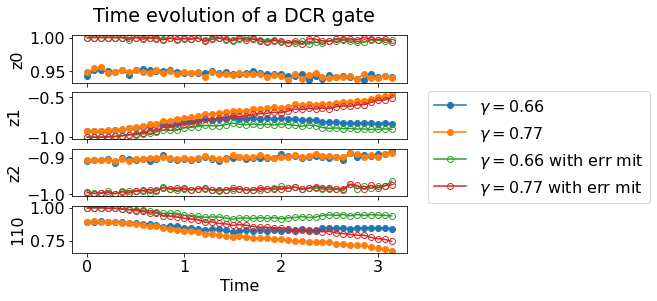

In [11]:
# import the utilities to process the experiments
import util
data = util.rearange_result(result, s0, meas, theta*2, c2r, dphi) # due to a factor 2 bug in this experiement data, a factor of 2 is added here to correct it.
data_mit = util.rearange_result(result_mit, s0, meas, theta*2, c2r, dphi)
data = data[0,2]
data_mit = data_mit[0,2]
fig = plt.figure()
gs = fig.add_gridspec(4,1)
axs = gs.subplots(sharex=True)
irs = [0,1,2,-2]
ylbs = ['z0', 'z1', 'z2', '110']
for i in range(4):
    ax = axs[i]
    ii = irs[i]
    ax.plot(theta, data[ii, :, 0], '-o', label='$\gamma=0.66$')
    ax.plot(theta, data[ii, :, 1], '-o', label='$\gamma=0.77$')
    ax.plot(theta, data_mit[ii, :, 0], '-o', fillstyle='none', label='$\gamma=0.66$ with err mit')
    ax.plot(theta, data_mit[ii, :, 1], '-o', fillstyle='none', label='$\gamma=0.77$ with err mit')
    ax.set(ylabel=ylbs[i])
    if i==0:
        ax.legend(bbox_to_anchor=(1.75,0))
axs[-1].set(xlabel='Time')
fig.suptitle('Time evolution of a DCR gate')
plt.show()
    

This plot shows the behaviors of a DCR gate applied to initial state '110'. For an ideal DCR gate, the state '110' should stay unchanged over the whole duration. From the real device results, the green line shows roughly a steady state with an control pulses amplitude ratio of 0.66. The diviation from '110' indicates the not well tuned parameter set. One evidence is that with another amaplitude ratio value of 0.77, the behaviors became much worse. 

It is also evident from this plot that the error mitigation technique gives about 20% improvement.

## 3-3 Time evolution of DCR based Trotterization circuit on Ibmq-jakarta

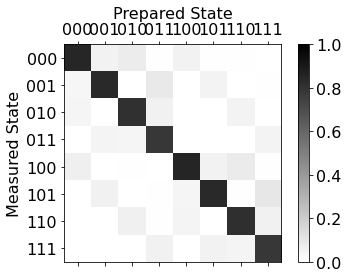

In [12]:
job = bk.retrieve_job('62534640182d02fd344c45e8')
result = job.result()

## or load from saved results if the job has been removed.
#import pickle
#with open('result_trotter_tval.pk', 'rb') as fp:
#    result = pickle.load(fp)

# the parameters used in this experiment
c2r = [0.66, 0.77]
dphi = [0]
s0 = [One^One^Zero]
theta = np.linspace(0, np.pi, 45)
meas = ['xxx', 'yyy', 'zzz'] # not all result will be presented in this notebook
# apply error mitigation
mstls = ['000', '001', '010', '011', '100', '101', '110', '111']
mfitter = CompleteMeasFitter(result, mstls, circlabel='mit')
result_mit = mfitter.filter.apply(result)
mfitter.plot_calibration()

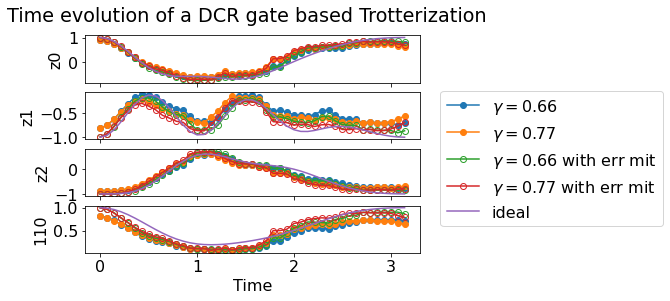

In [13]:
# import the utilities to process the experiments
import util
data = util.rearange_result(result, s0, meas, theta*2, c2r, dphi)
data_mit = util.rearange_result(result_mit, s0, meas, theta*2, c2r, dphi)
data = data[0,2]
data_mit = data_mit[0,2]
# calculate theoretical results
data_th = []
for th in theta:
    st = util.apply_UT(One^One^Zero, th, 4, [0,3,2,5,1,4])
    z2 = (~(st) @ ((Z^I^I)@st)).eval()
    z1 = (~(st) @ ((I^Z^I)@st)).eval()
    z0 = (~(st) @ ((I^I^Z)@st)).eval()
    p = ((~(One^One^Zero)) @ st).eval()
    data_th.append([np.real(z0), np.real(z1), np.real(z2), np.real(p)])
data_th = np.asarray(data_th)
# plot the data
fig = plt.figure()
gs = fig.add_gridspec(4,1)
axs = gs.subplots(sharex=True)
irs = [0,1,2,-2]
ylbs = ['z0', 'z1', 'z2', '110']
for i in range(4):
    ax = axs[i]
    ii = irs[i]
    ax.plot(theta, data[ii, :, 0], '-o', label='$\gamma=0.66$')
    ax.plot(theta, data[ii, :, 1], '-o', label='$\gamma=0.77$')
    ax.plot(theta, data_mit[ii, :, 0], '-o', fillstyle='none', label='$\gamma=0.66$ with err mit')
    ax.plot(theta, data_mit[ii, :, 1], '-o', fillstyle='none', label='$\gamma=0.77$ with err mit')
    ax.plot(theta, data_th[:,i], label='ideal')
    ax.set(ylabel=ylbs[i])
    if i==0:
        ax.legend(bbox_to_anchor=(1.75,0))
axs[-1].set(xlabel='Time')
fig.suptitle('Time evolution of a DCR gate based Trotterization')
plt.show()

This experiment is done with first order 4 step Trotterization and run on Ibmq_jakarta with 16384 shots. The plot from real device run and the theoretical results match well and the improvement from error mitigation can still be noticed. The difference from the control pulse amplitude ratio is not as noticable as in the plot for a single DCR gate characterization since each gate in the Trotterization setup evolve for a shorter time. The difference is indeed small in the single DCR's plot at $t=\pi/4$. Of cause, much worse performance can be expected if this ratio diviate too much.

# 3-4 Zero Noise Extrapolation and real-time parameter selection
This section illustrates the flow using simulations since the real device results are not yet available by the time of writing. For the corresponding gate base circuit, the DCR gates aare replaced by $Rzx(1,3)\cdot Rzx(5,3)$, i.e. two $Rzx$ gates. The reverse gates are easily substituted by negative angle values. 

The real-time parameter selection is applied to the control pulse amplitude ratio, $\gamma$. The idea is to add the corresponding single DCR gate applied to the initial state and monitor the resulting state. Since the '110' initial state should be kept unchange with the ideal DCR Hamiltonian, the probablity of getting '110' state after a time interval of $target\_time/trotter\_steps$ is used as the criteria. The parameter that gives the highest probablity is selected. This selection is done in postprocess, which means the job will include the whole tomography circuits for all parameter values. For 300 circuits limit, 5 parameter sets can be fully evaluated.

In [107]:
bksim = get_backend('jakarta',0) # simulation backend
target_time = np.pi
initial_state = One^One^Zero
shots = bksim.configuration().max_shots
rep = 1
nr = [0,1] # for ZNE. 0: original circuit; 1: with reverse-gate base duplications
trotter_steps = 4
order = 1
hs = 'xzy' # op orders
qubits = [3,1,5] # ordered for the DCR gates.
# those two parameters are actually useless place holder since this is not a real device run
# they help illustrating the whole experiment flow
c2r = np.linspace(0.6, 0.7, 5) # for 'real-time selection'
dphi = 0 
jname = 'sim'

getting backend: jakarta


ibmqfactory.load_account:WARNING:2022-04-18 22:30:36,364: Credentials are already in use. The existing account in the session will be replaced.


In [108]:
# generate corresponding error mitigation circuit
mqcs, mstls = gen_mitigation_circs(bksim, qubits, trotter_steps, hs, order, nr)
# generate the single DCR gates for real-time selecting of parameters
cqcs = gen_ccr_calibration_circs(bksim, target_time, trotter_steps, qubits, initial_state, c2r)
# generate all state tomography circuits
tqcs = gen_tomo_experiments(bksim, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + cqcs + tqcs

mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
ccr_xzy_s1_o0_n0_r0.60_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.62_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.65_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.67_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.70_d0.00_t0.79
fc_xzy_s4_o1_n0_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.67_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.67_d0.00

In [113]:
# run the simultion
job = submit_expr(bksim, qcs, shots=shots, jname=jname, rep=rep)
result = retrieve_results(job)

total circs: 291
job id: 43e3dc95-252d-4fc1-8aeb-60d104d5508d
Job Status: job has successfully run


In [117]:
result = result[0] # only one repeation
# build the error mitigator from results.
mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
# group the results according to the parameters and the ZNE setting
gres = group_results(result, qcs, mfitters)
# find from the real time calibration circuit for the best parameter, and keep only the results of those
ic2r = pick_c2r(result, target_time, trotter_steps, initial_state, hs, c2r)
gres = pick_c2r_result(gres, c2r[ic2r])
# process ZNE calculation
fid = cal_fidelity_zne(gres, initial_state)

Making results for: fc_xzy_s4_o1_n0_r0.60_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.60_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.62_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.62_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.65_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.65_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.67_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.67_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.70_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.70_d0.00_t3.14
ccr_xzy_s1_o0_n0_r0.60_d0.00_t0.79 88524 {'001': 8, '100': 3797, '110': 88524, '010': 4883, '101': 103, '011': 134, '000': 303, '111': 2248}
ccr_xzy_s1_o0_n0_r0.62_d0.00_t0.79 88549 {'001': 6, '101': 99, '010': 4895, '110': 88549, '100': 3736, '111': 2310, '000': 273, '011': 132}
ccr_xzy_s1_o0_n0_r0.65_d0.00_t0.79 88624 {'001': 11, '101': 105, '010': 4760, '110': 88624, '100': 3827, '000': 292, '011': 129, '111': 2252}
ccr_xzy_s1_o0_n0_r0.67_d0.00_t0.79 88

Since this is a circuit base simulation, the selection of $\gamma$ is just for flow illustration. The final fidelity is enlightening. The ZNE technique boosted the fidelity from 0.86% to 0.96.

# 4 Real device results
This section presents the real results from running on Ibmq_jakarta. By the time of submission, only one repeatition of the final solution has finished, giving a fidelity of 0.9570. Full statistical analysis is done with a solution using non-optimal control pulse amplitude value in section 4-2. Section 4-3 presents other worse performed Trotterization setting for more insights.

Follow code blocks retrieve jobs from Ibmq-jakarta and process them to display the results.

## 4-1 Full solution result
This result has included all the above mentioned techniques. By the time of submission, only one repeatition has finished and it gives a fidelity of $\textbf{0.9570}$. It runs first order four step Trotterization. The selected $\gamma$ value is 0.625. From the raw DCR based circuit, the measured fidelity is about 0.7034 and the error mitigation improves it to 0.9177. Then ZNE gives it a final boost to 0.9570. Details can be seen from the out put of the following two code blocks.

Sufficient repeatition has been run with a not optimal heuristic $\gamma$ value of 0.66. It shows the diviation is very small if we remove outlier (removing both the best and the worst data). So we could reasonably expect the final result to have similar small diviation and average around 0.9570. Details of the $\gamma=0.66$ results are in section 4-2.

In [ ]:
from base import *
# experiment setting
target_time = np.pi
initial_state = One^One^Zero
bk = get_backend('jakarta',1)
is_real = not (isinstance(bk, QasmSimulator))
shots = bk.configuration().max_shots
rep = 8
order = 1
nr = [0,1]
trotter_steps = 4
hs = 'xzy'
qubits = [3, 1, 5] # t, c, c
c2r = np.linspace(0.6, 0.7, 5)
dphi = 0
jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)
mfitter = None
schds = None
qcs = None

# recreate the circuit to be used in results processing
mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
cqcs = gen_ccr_calibration_circs(bk, target_time, trotter_steps, qubits, initial_state, c2r)
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + cqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} ccr, {} tomography".format(jname, len(qcs), len(mqcs), len(cqcs), len(tqcs)))

# retrieve results
jids = ['625a31e50d8f190bc7ac1684', '625a324f0d8f194de7ac1685','625a32bca7e9665c79dee46e','625a331a8e4b23458bd3062c','625a337be1f245e423eb68d7','625a33db8e4b2320ccd3062f','625a343e3bbc9fdb6e735833','625a349bf1fb8d4cea3ad536']
jobs = []
results = []
for jid in jids:
    job = bk.retrieve_job(jid)
    if not job.done():
        continue
    result = job.result()
    jobs.append(job)
    results.append(result)
print('total repeatitions done: ', len(results))
    
## if jobs are no longer available, use the stored one
#import pickle
#with open('results_{}.pk'.format(jname), 'rb') as fp:
#    results = pickle.load(fp)

# process results and report
fids = []
for result in results:
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    ic2r = pick_c2r(result, target_time, trotter_steps, initial_state, hs, c2r)
    gres = pick_c2r_result(gres, c2r[ic2r])
    fid = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
if len(fids)>5:
    fids.remove(min(fids))
    fids.remove(max(fids))
    print(fids)
    print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

getting backend: jakarta
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
ccr_xzy_s1_o0_n0_r0.60_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.62_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.65_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.67_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.70_d0.00_t0.79
fc_xzy_s4_o1_n0_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.67_d0.00_t3.14
fc

Let's see the contribution of error mitigation by not using the mitigator.

In [15]:
fids = []
for i, result in enumerate(results):
    print("Rep. ", i)
    gres = group_results(result, qcs, None)
    ic2r = pick_c2r(result, target_time, trotter_steps, initial_state, hs, c2r)
    gres = pick_c2r_result(gres, c2r[ic2r])
    fid = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
if len(fids)>5:
    fids.remove(min(fids))
    fids.remove(max(fids))
    print(fids)
    print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

Rep.  0
Making results for: fc_xzy_s4_o1_n0_r0.60_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.60_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.62_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.62_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.65_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.65_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.67_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.67_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n0_r0.70_d0.00_t3.14
Making results for: fc_xzy_s4_o1_n1_r0.70_d0.00_t3.14
ccr_xzy_s1_o0_n0_r0.60_d0.00_t0.79 84922 {'000': 1031, '001': 62, '010': 5504, '011': 130, '100': 5749, '101': 717, '110': 84922, '111': 1885}
ccr_xzy_s1_o0_n0_r0.62_d0.00_t0.79 84973 {'000': 1109, '001': 61, '010': 5451, '011': 147, '100': 5857, '101': 623, '110': 84973, '111': 1779}
ccr_xzy_s1_o0_n0_r0.65_d0.00_t0.79 84868 {'000': 1246, '001': 65, '010': 5395, '011': 120, '100': 5929, '101': 557, '110': 84868, '111': 1820}
ccr_xzy_s1_o0_n0_r0.67_

## 4-2 First order four step Trotterization with $\gamma=0.66$

In [16]:
from base_1 import *
# experiment setting
target_time = np.pi
initial_state = One^One^Zero
bk = get_backend('jakarta',1)
rep = 8
order = 1
nr = [0,1]
trotter_steps = 4
hs = 'xzy'
qubits = [3, 1, 5] # t, c, c
c2r = [0.66]
dphi = 0

jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)
mfitter = None
schds = None
qcs = None

# recreate the circuit to be used in results processing
mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} tomography".format(jname, len(qcs), len(mqcs), len(tqcs)))

# retrieve results
jids = ['62592bd83bbc9fe96c73536a', '62592c0273689429bec8b3d7', '62592c2f35e1ec171b252eab', '62592c5b9e31155152838266', '62592c8935e1ec2f07252eaf', '62592cae736894061fc8b3d9', '62592ce5e1f2454166eb63e6','62592d1ba7e966ed4fdedfc7']
jobs = []
results = []
for jid in jids:
    job = bk.retrieve_job(jid)
    result = job.result()
    jobs.append(job)
    results.append(result)
    
## if jobs are no longer available, use the stored one
#import pickle
#with open('results_{}.pk'.format(jname), 'rb') as fp:
#    results = pickle.load(fp)

# process results and report
fids0 = [] # the original circuit
fids1 = [] # the circuit with multipled DCR gates
fids = []
for i, result in enumerate(results):
    print("Rep. ", i)
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    fid, fid0, fid1 = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
    fids0.append(fid0)
    fids1.append(fid1)
print('Final state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

# remove outliers
fids.remove(min(fids))
fids.remove(max(fids))
print(fids)
print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

getting backend: jakarta


ibmqfactory.load_account:WARNING:2022-04-23 16:42:31,752: Credentials are already in use. The existing account in the session will be replaced.


Experiment plc_xzy_o1_s4_st100000 has 70 circuits: 16 mit, 54 tomography
Rep.  0
fidelity: 0.8962576515198633, 0.6593782151160255 -> 0.8983524270348618
Rep.  1
fidelity: 0.8868595273120359, 0.6300759446014574 -> 0.9019310918973166
Rep.  2
fidelity: 0.46798667256261284, 0.31417312197577635 -> 0.5413512125589971
Rep.  3
fidelity: 0.889296189545613, 0.6255121700114452 -> 0.9043037303067557
Rep.  4
fidelity: 0.8948460508174977, 0.6239887588213654 -> 0.902949570282094
Rep.  5
fidelity: 0.8918047884811675, 0.6217458701997363 -> 0.9042096522522634
Rep.  6
fidelity: 0.8896688073300348, 0.6269659239324705 -> 0.9052602606344926
Rep.  7
fidelity: 0.8828008040036825, 0.6046155558810388 -> 0.9071819339467835
Final state tomography fidelity = 0.8582 ± 0.1198
[0.8983524270348618, 0.9019310918973166, 0.9043037303067557, 0.902949570282094, 0.9042096522522634, 0.9052602606344926]
Final state tomography fidelity with outlier removed = 0.9028 ± 0.0023


In the above results, for each repeatition the last number is the fidelity from ZNE calclulation. The former two numbers are the standard original circuit fidelity and that with multipled DCR circuit. The benifit from ZNE can be readily observed. It is also worth noting among the 8 repeatitions, Rep.2 is an obvious outlier. It could be caused by a special one-time event that happens during this repeatition which may not be reproducable. From a stastical point of view, the outlier influence is often removed by ignoring both the best and worse data. With this, this experiement got average fidelity of 0.9028 with standard diviation of 0.0023.

We can also check the contribution of error mitigation by checking the results without applying the mitigator:

In [17]:
fids = []
for i, result in enumerate(results):
    print("Rep. ", i)
    gres = group_results(result, qcs, None)
    fid, _, __ = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
fids.remove(min(fids))
fids.remove(max(fids))
print(fids)
print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

Rep.  0
fidelity: 0.718935680374084, 0.39984320110503313 -> 0.8646986806616677
Rep.  1
fidelity: 0.7201017309746539, 0.4027678991207494 -> 0.8644511940244635
Rep.  2
fidelity: 0.3842882542133814, 0.20937895073439347 -> 0.4717429059528754
Rep.  3
fidelity: 0.7224586697472583, 0.3981087955337252 -> 0.8692018900705045
Rep.  4
fidelity: 0.7248534208690319, 0.40102301951777075 -> 0.8716920584183228
Rep.  5
fidelity: 0.7249589806712275, 0.3955484358991345 -> 0.8739095949109286
Rep.  6
fidelity: 0.7156665287468269, 0.39575096369003 -> 0.86205577138644
Rep.  7
fidelity: 0.690315618012841, 0.3737530642596652 -> 0.8354545168470375
state tomography fidelity = 0.8142 ± 0.1299
[0.8646986806616677, 0.8644511940244635, 0.8692018900705045, 0.8716920584183228, 0.86205577138644, 0.8354545168470375]
Final state tomography fidelity with outlier removed = 0.8613 ± 0.0120


This result is worse than the previous one, although not by a large amount. It confirms the benefit from error mitigation.

## 4-3 Other Trotterization settings
The same experiment is also run for second order four step Trotterization and first order eight step Trotterization. Athough they showed worse performance, we can try to get some insight in this solution.

In [181]:
from base_1 import *
target_time = np.pi
initial_state = One^One^Zero
bk = get_backend('jakarta',1)
rep = 8
order = 2
nr = [0,1]
trotter_steps = 4
hs = 'xzy'
qubits = [3, 1, 5] # t, c, c
c2r = [0.66]
dphi = 0

print("SECOND ORDER FOUR STEP TROTTERIZATION")
jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)
mfitter = None
schds = None
qcs = None

mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} tomography".format(jname, len(qcs), len(mqcs), len(tqcs)))

jids = ['62592c59e3b67f3a653ab4b9','62592c9ef1fb8dd02e3ad066','62592cede1f24510f0eb63e7','62592d390d8f19620eac11c9','62592d7d8e4b23d62cd3014a','62592da80d8f196071ac11cb','62592dd43bbc9f7d2573536f','62592e01e1f2456937eb63f1']
jobs = []
results = []
for jid in jids:
    job = bk.retrieve_job(jid)
    result = job.result()
    jobs.append(job)
    results.append(result)
    
## if jobs are no longer available, use the stored one
#import pickle
#with open('results_{}.pk'.format(jname), 'rb') as fp:
#    results = pickle.load(fp)
    
fids = []
for result in results:
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    fid = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
fids.remove(min(fids))
fids.remove(max(fids))
print(fids)
print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

# first order 8 step
print("\nFIRST ORDER EIGHT STEP TROTTERIZATION")
order = 1
trotter_steps = 8
jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)
mfitter = None
schds = None
qcs = None

mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} tomography".format(jname, len(qcs), len(mqcs), len(tqcs)))

jids = ['62592c940d8f197dbfac11c5','62592ce87368945739c8b3dd','62592d3ea7e966cd43dedfc8','62592d819e3115077b83826a','62592db18e4b2395eed3014b','62592de435e1ecb46d252eb6','62592e143bbc9f43d9735371','62592e3fe3b67f28783ab4c4']
jobs = []
results = []
for jid in jids:
    job = bk.retrieve_job(jid)
    result = job.result()
    jobs.append(job)
    results.append(result)
    
## if jobs are no longer available, use the stored one
#with open('results_{}.pk'.format(jname), 'rb') as fp:
#    results = pickle.load(fp)
    
fids = []
for result in results:
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    fid = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
fids.remove(min(fids))
fids.remove(max(fids))
print(fids)
print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

getting backend: jakarta


ibmqfactory.load_account:WARNING:2022-04-23 12:39:02,590: Credentials are already in use. The existing account in the session will be replaced.


SECOND ORDER FOUR STEP TROTTERIZATION
Experiment plc_xzy_o2_s4_st100000 has 70 circuits: 16 mit, 54 tomography
fidelity: 0.6008894965632398, 0.43152526526107254 -> 0.6198162325384423
fidelity: 0.6110581599356468, 0.4923598598999652 -> 0.5401445806279241
fidelity: 0.6080312329550298, 0.18269427782880435 -> 0.6506775141402789
fidelity: 0.6015096952422445, 0.42860695134218224 -> 0.625393888192611
fidelity: 0.611674000061365, 0.510834218736801 -> 0.5479856200852627
fidelity: 0.6161323813602362, 0.49974679610381195 -> 0.6227183286768369
fidelity: 0.6095477222220805, 0.33342448579064476 -> 0.6580173395814952
fidelity: 0.5896137162015406, 0.4968301652312755 -> 0.5893780593227952
state tomography fidelity = 0.5449 ± 0.1090
[(0.6198162325384423, 0.6008894965632398, 0.43152526526107254), (0.6506775141402789, 0.6080312329550298, 0.18269427782880435), (0.625393888192611, 0.6015096952422445, 0.42860695134218224), (0.5479856200852627, 0.611674000061365, 0.510834218736801), (0.6227183286768369, 0.616

Both results showed worse fidelity compared with the first order four step Trotterization result. The major reason should be that the longer circuit affected more by noise. Another more interesting notice is that the improvement from ZNE in those settings is not guaranteed. In some repeatitions, the ZNE reduced the fidelity. One possible reason could be the imperfect DCR gates. Some secondary Hamiltonian terms or non depolarization noise may become more significant in those Trotterization settings.

It is worth noting that in these two sets of experiments, results with/without outlier removal are almost identical. This is another indicator that removing both worst and best data from the repeatitions could be a standard postprocessing stratergy to improve the consistency of real device runs.

# 5 Code to reproduce the experiments
The final experiment can be done by running the python code directly: $python \space base.py$.

Another equivalent way is to run this code block in this not book. The current output of this code block is from simulation to ensure it runs fine (with get_backend('jakarta',0)). Code has been changed to run with real device (get_backend('jakarta',1)).

## 5-1 Final solution

In [19]:
from base import *
# get_backend will return the jakarta backend. If this fails for environment reason, please provide the jakarta backend directly
bk = get_backend('jakarta',1)
is_real = not (isinstance(bk, QasmSimulator))
# define the problem
target_time = np.pi
initial_state = One^One^Zero
rep = 8
shots = bk.configuration().max_shots
qubits = [3, 1, 5] # target qubit, control 0, control 1
# first order four step Trotterization
order = 1
trotter_steps = 4
hs = 'xzy'
# DCR
c2r = np.linspace(0.6, 0.7, 5)
dphi = 0
# ZNE
nr = [0,1]
jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)

# build the necessary circuits
mfitter = None
schds = None
qcs = None
# error mitigation circuits
mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
# calibration circuit to find best c2r value
cqcs = gen_ccr_calibration_circs(bk, target_time, trotter_steps, qubits, initial_state, c2r)
# tomography circuits
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + cqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} ccr, {} tomography".format(jname, len(qcs), len(mqcs), len(cqcs), len(tqcs)))

# build schedules
qsub = qcs
if bk.configuration().open_pulse:
    schds = schedule(qcs, bk)
    qsub = schds

# run the circuits
jobs = submit_expr(bk, qsub, shots=shots, jname=jname, rep=rep)
results = retrieve_results(jobs)

# process results
fids = []
for result in results:
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    ic2r = pick_c2r(result, target_time, trotter_steps, initial_state, hs, c2r)
    gres = pick_c2r_result(gres, c2r[ic2r])
    fid = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
# remove outliers
fids.remove(min(fids))
fids.remove(max(fids))
print(fids)
print('Final state tomography fidelity with outlier removed = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

getting backend: jakarta


ibmqfactory.load_account:WARNING:2022-04-23 16:45:25,947: Credentials are already in use. The existing account in the session will be replaced.


mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n0_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
mit_xzy_s4_o1_n1_r1.00_d0.00_t0.00
ccr_xzy_s1_o0_n0_r0.60_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.62_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.65_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.67_d0.00_t0.79
ccr_xzy_s1_o0_n0_r0.70_d0.00_t0.79
fc_xzy_s4_o1_n0_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.60_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.62_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.65_d0.00_t3.14
fc_xzy_s4_o1_n0_r0.67_d0.00_t3.14
fc_xzy_s4_o1_n1_r0.67_d0.00

## 5-2 Partial solution without calibration

The following code block is the code to reproduce the results shown in section 4-1. Instead of retrieving results, it submit jobs to real device and get the results. Other part remain not changed.

In [ ]:
from base_1 import *
# experiment setting
target_time = np.pi
initial_state = One^One^Zero
bk = get_backend('jakarta',1)
rep = 8
order = 1
nr = [0,1]
trotter_steps = 4
hs = 'xzy'
qubits = [3, 1, 5] # t, c, c
c2r = [0.66]
dphi = 0

jname = 'plc_{}_o{}_s{}_st{}'.format(hs, order, trotter_steps, shots)
mfitter = None
schds = None
qcs = None

# recreate the circuit to be used in results processing
mqcs, mstls = gen_mitigation_circs(bk, qubits, trotter_steps, hs, order, nr)
tqcs = gen_tomo_experiments(bk, target_time, trotter_steps, qubits, initial_state, order=order, hs=hs, c2r=c2r, dphi=dphi, nr=nr)
qcs = mqcs + tqcs
print("Experiment {} has {} circuits: {} mit, {} tomography".format(jname, len(qcs), len(mqcs), len(tqcs)))

# build schedules
qsub = qcs
if bk.configuration().open_pulse:
    schds = schedule(qcs, bk)
    qsub = schds

# run the circuits
jobs = submit_expr(bk, qsub, shots=shots, jname=jname, rep=rep)
results = retrieve_results(jobs)

# process results and report
fids0 = [] # the original circuit
fids1 = [] # the circuit with multipled DCR gates
fids = []
for i, result in enumerate(results):
    print("Rep. ", i)
    mfitters = get_fitters(result, mstls, trotter_steps, hs, order, nr)
    gres = group_results(result, qcs, mfitters)
    fid, fid0, fid1 = cal_fidelity_zne(gres, initial_state)
    fids.append(fid)
    fids0.append(fid0)
    fids1.append(fid1)
print('Final state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

In [182]:
import qiskit.tools.jupyter
%qiskit_version_table

# Reference
\[1\] Chad Tyler Rigetti, *Quantum gates for superconducting qubits*, Yale University ProQuest Dissertations Publishing,  2009. 3361560. 

\[2\] Easwar Magesan, Jay M. Gambetta, *Effective Hamiltonian models of the cross-resonance gate*, Phys. Rev. A 101, 052308 (2020)
(https://arxiv.org/abs/1804.04073)

\[3\] Andre He, Benjamin Nachman, Wibe A. de Jong, Christian W. Bauer, *Resource Efficient Zero Noise Extrapolation with Identity Insertions*, Phys. Rev. A 102, 012426 (2020)
(https://arxiv.org/abs/2003.04941)